In [1]:
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

import clmm
import numpy as np
from numpy import random
from clmm import Cosmology
from clmm.support import mock_data as mock
from chainconsumer import ChainConsumer
import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble'] = [r'\usepackage{pxfonts, mathpazo}']
plt.rc('text', usetex=True)

In [2]:
np.random.seed(0)
# Define cosmological parameters
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

cluster_m     = 1.e15 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination
shapenoise    = 0.01  # True ellipticity standard variation
photoz_noise  = 0.01

# Create galaxy catalog and Cluster object

def create_nc_data_cluster_wll (theta, g_t, z_source, z_cluster, cosmo, dist, sigma_z = None, sigma_g = None):
    r  = clmm.convert_units (theta, "radians", "Mpc", redshift = z_cluster, cosmo = cosmo)
    obs = Ncm.Matrix.new (len (theta), 3)

    for i in range (len (theta)):
        obs.set (i, 0, r[i])
        obs.set (i, 1, z_source[i])
        obs.set (i, 2, g_t[i])

    gsdp  = Nc.GalaxySDPositionFlat ()
    gsdzp = Nc.GalaxySDZProxyGauss ()
    gsds  = Nc.GalaxySDShapeGauss ()

    gsdp.set_z_lim (Ncm.Vector.new_array ([0.5-0.01, 7+0.01]))
    gsdp.set_r_lim (Ncm.Vector.new_array ([min (r)-0.01, max (r)+0.01]))
    gsdzp.set_z_lim (Ncm.Vector.new_array ([0.5-0.01, 7+0.01]))
    gsdzp.set_sigma (sigma_z)
    gsds.set_sigma (sigma_g)

    gwll = Nc.GalaxyWLLikelihood (s_dist=gsds, zp_dist=gsdzp, rz_dist=gsdp)
    gwll.set_obs (obs)

    ga = Ncm.ObjArray.new ()
    ga.add (gwll)

    dcwll = Nc.DataClusterWLL (galaxy_array = ga, z_cluster = z_cluster)
    dcwll.set_init (True)
    
    return dcwll

def create_fit_obj (data_array, mset):
    dset = Ncm.Dataset.new ()
    for data in data_array:
        dset.append_data (data)
    lh = Ncm.Likelihood.new (dset)
    fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)

    return fit

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#..............................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:02.1726250
#  iteration            [000211]
#  function evaluations [000213]
#  gradient evaluations [000000]
#  degrees of freedom   [009998]
#  m2lnL     =     53885.9716802797 (     53885.972 )
#  Fit parameters:
#     9.99824285988593     15.0293441076799    
#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterWLL
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Mod


(process:20588): NUMCOSMO-WARNING **: 11:40:20.572: ncm_fit_fisher_to_covar: covariance matrix not positive definite, errors are not trustworthy.


# NcmMSetCatalog: Current mean:   43484        9.9914       15.029     
# NcmMSetCatalog: Current msd:    69.905       0.00041451   0.0031993  
# NcmMSetCatalog: Current sd:     988.6        0.005862     0.045246   
# NcmMSetCatalog: Current var:    9.7733e+05   3.4363e-05   0.0020472  
# NcmMSetCatalog: Current tau:    1            1            1          
# NcmMSetCatalog: Current skfac: -nan         -nan         -nan        
# NcmMSetCatalog: Maximal Shrink factor = 1e+10                 
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `1':
# NcmMSetCatalog: Constant break point at `0':
# NcmFitESMCMC:last ensemble variance of -2ln(L):       973024.469625494 (2n = 4), min(-2ln(L)) =       41890.5591120218.
# Task:NcmFitESMCMC, completed: 200 of 200, elapsed time: 00:00:01.7796
# Task:NcmFitESMCMC, mean time: 00:00:00.0088 +/- 00:00:00.0088
# Task:NcmFitESMCMC, time

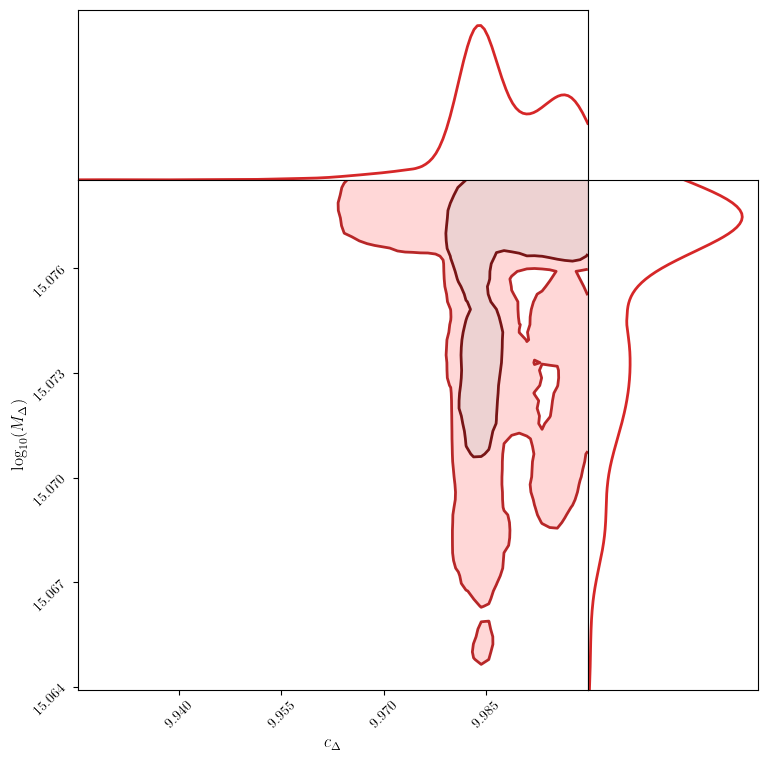

In [3]:
# np.random.seed(10)

moo = clmm.Modeling (massdef='mean', delta_mdef=200, halo_profile_model='nfw')
moo.set_cosmo(cosmo)
mset = moo.get_mset ()

MDelta_pi = mset.param_get_by_full_name ("NcHaloDensityProfile:log10MDelta")
cDelta_pi = mset.param_get_by_full_name ("NcHaloDensityProfile:cDelta")

mset.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FREE)
mset.prepare_fparam_map ()

data = mock.generate_galaxy_catalog (cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec, photoz_sigma_unscaled=photoz_noise)
gc = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)
gc.compute_tangential_and_cross_components(geometry="flat")

ggt = create_nc_data_cluster_wll (gc.galcat['theta'], gc.galcat['et'], gc.galcat['z'], cluster_z, cosmo, cosmo.dist, sigma_z=photoz_noise, sigma_g=shapenoise)
fit = create_fit_obj ([ggt], mset)
fit.run (Ncm.FitRunMsgs.SIMPLE)
fit.obs_fisher ()
fit.log_info ()
fit.log_covar ()

print(10**mset.param_get(MDelta_pi.mid, MDelta_pi.pid))

Ncm.func_eval_set_max_threads (4)
Ncm.func_eval_log_pool_stats ()

init_sampler = Ncm.MSetTransKernGauss.new (0)
init_sampler.set_mset (mset)
init_sampler.set_prior_from_mset ()
init_sampler.set_cov_from_rescale (1.0e-1)

nwalkers = 200
stretch = Ncm.FitESMCMCWalkerAPES.new (nwalkers, mset.fparams_len ())
esmcmc  = Ncm.FitESMCMC.new (fit, nwalkers, init_sampler, stretch, Ncm.FitRunMsgs.SIMPLE)
esmcmc.set_auto_trim_div (100)
esmcmc.set_max_runs_time (2.0 * 60.0)
esmcmc.set_nthreads(4)
esmcmc.start_run()
esmcmc.run(10000/nwalkers)
esmcmc.end_run()

mcat = esmcmc.peek_catalog()
rows = np.array([mcat.peek_row(i).dup_array() for i in range(nwalkers * 10, mcat.len())])
params = ["$" + mcat.col_symb(i) + "$" for i in range (mcat.ncols())]

partial = ChainConsumer()
partial.add_chain(rows[:,1:], parameters=params[1:], name=f"$\sigma_{{\epsilon^s}} = {shapenoise}$")
partial.configure(spacing=0.0, usetex=True, colors='#D62728', shade=True, shade_alpha=0.2, bar_shade=True, smooth=True, kde=True, legend_color_text=False, linewidths=2)

CC_fig = partial.plotter.plot(figsize=(8, 8), truth=[4, 15])

fig = plt.figure(num=CC_fig, figsize=(8,8), dpi=300, facecolor="white")
